In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from getpass import getpass
token = getpass('Enter your GitHub PAT: ')

Enter your GitHub PAT: ··········


In [ ]:
!git config --global user.email "senadhithimanya777@gmail.com"
!git config --global user.name "senadhi-Thimanya"

In [ ]:
!git clone https://{token}@github.com/senadhi-Thimanya/Telco-Churn-Binary-Classification.git

fatal: destination path 'Telco-Churn-Binary-Classification' already exists and is not an empty directory.


In [ ]:
import pandas as pd

In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/ML/Coursework/Telco-Churn.csv'
df = pd.read_csv(file_path)
print(df.head())  # Quick peek at first 5 rows
print(df.shape)   # (7043, 21)

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [ ]:
# Data types and non-null counts
df.info()  # Shows TotalCharges is object (string), needs fixing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
# Summary statistics for numerical columns
df.describe()  # tenure, MonthlyCharges, TotalCharges (after conversion)

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [ ]:
# Check for missing values
print(df.isnull().sum())  # Usually none, but TotalCharges has 11 blanks

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [ ]:
#Convert TotalCharges to numeric (blanks become NaN)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print(df['TotalCharges'].isnull().sum())  # Should be 11

11


In [ ]:
df.fillna({'TotalCharges': 0}, inplace=True)
# Or df.fillna({'TotalCharges': df['TotalCharges'].median()})

In [ ]:
#Drop customerID (irrelevant for analysis)
df.drop('customerID', axis=1, inplace=True)

# Explore Distributions and Imbalances

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

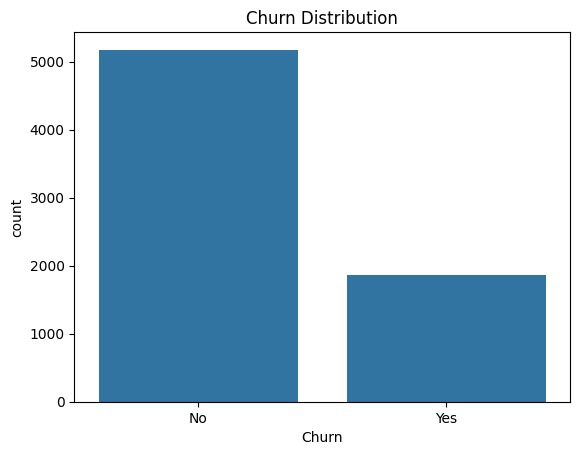

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


In [ ]:
#Target Distribution (Churn imbalance)
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.show()
print(df['Churn'].value_counts(normalize=True))  # ~73% No, 27% Yes

Insight: Imbalanced class – consider this for modeling (e.g., use F1-score).

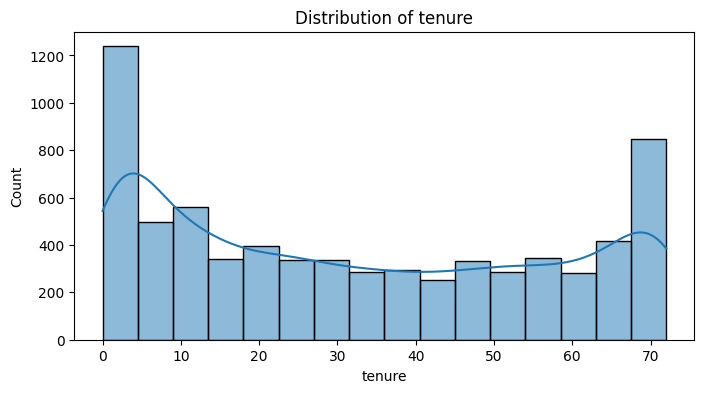

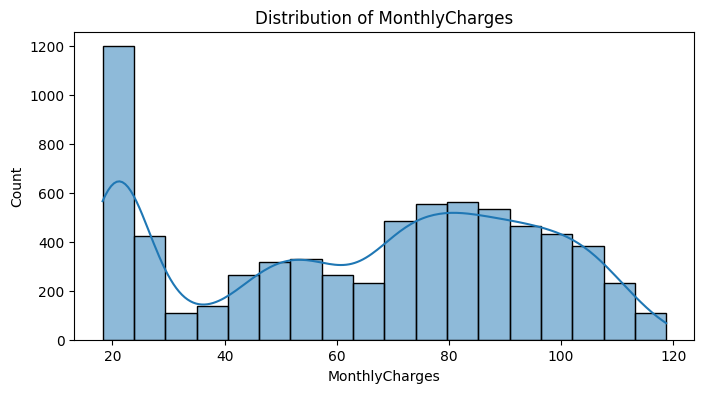

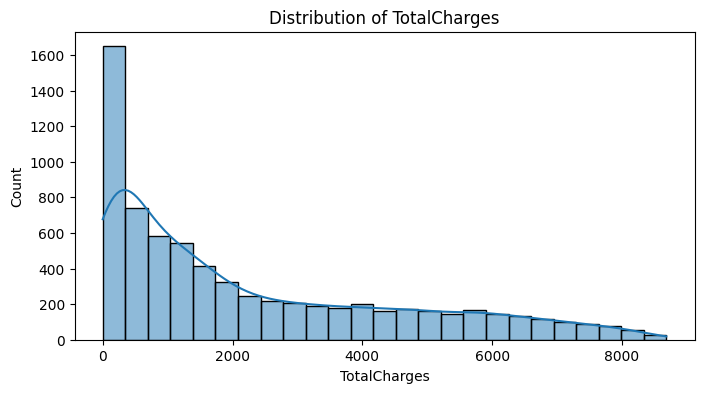

In [ ]:
#Numerical Features Distributions (tenure, MonthlyCharges, TotalCharges)
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

Insights: Tenure skewed right (many short-term customers); Charges bimodal (clusters around low/high plans).

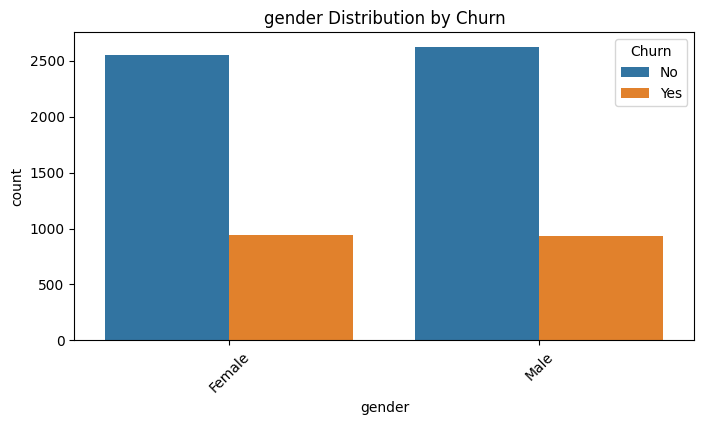

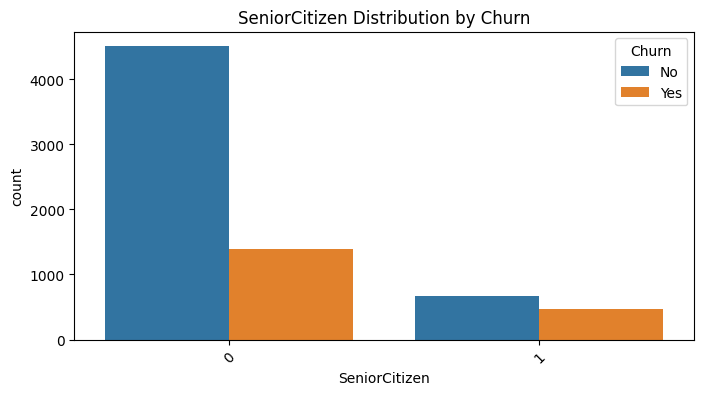

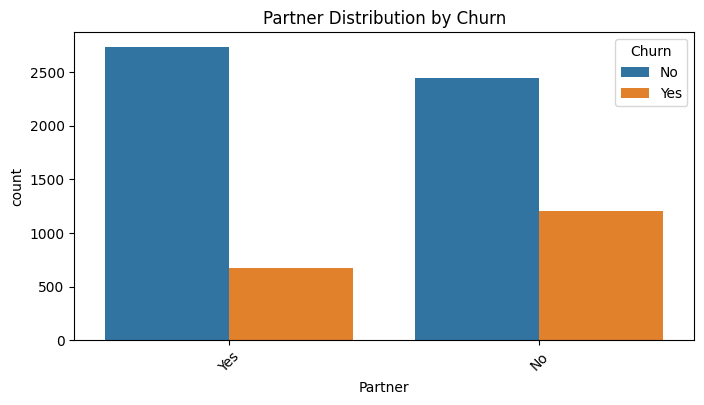

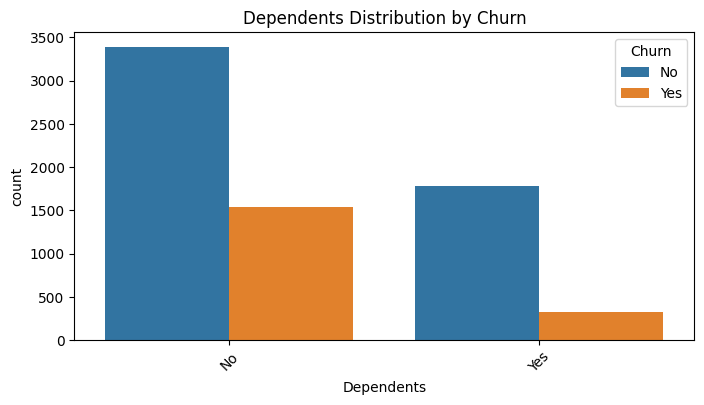

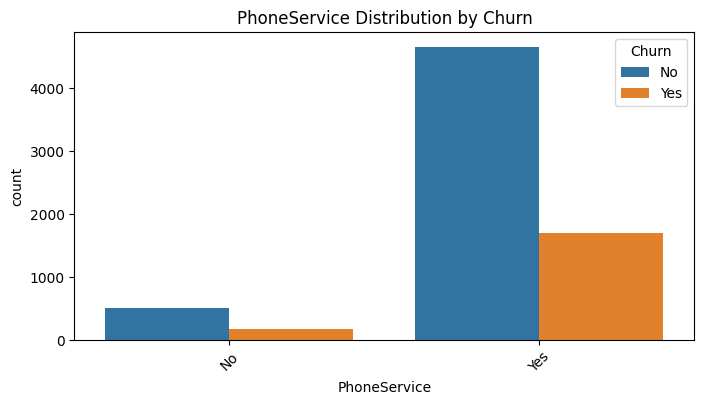

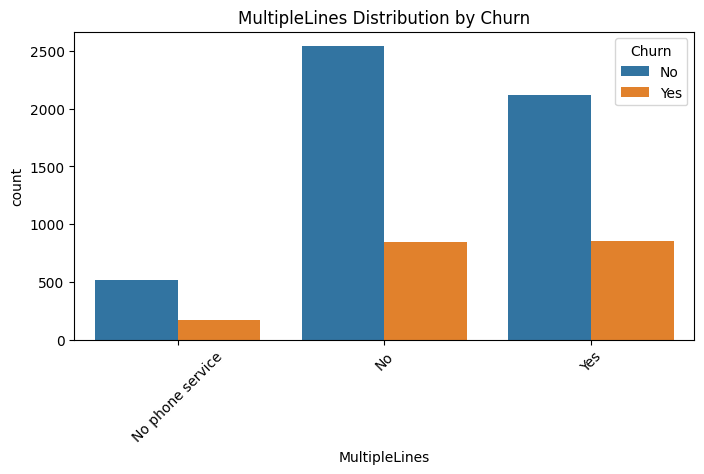

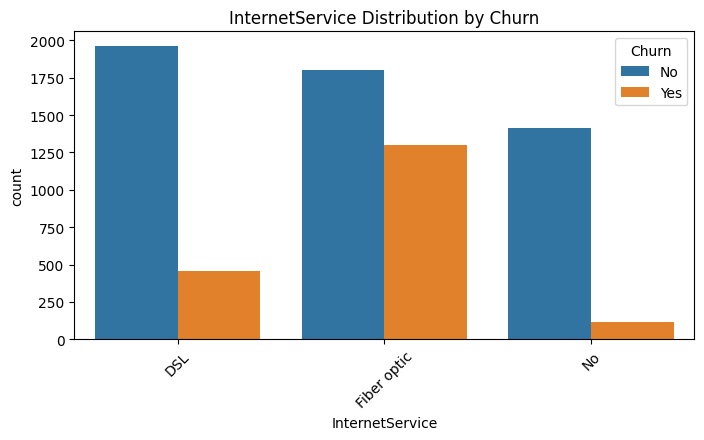

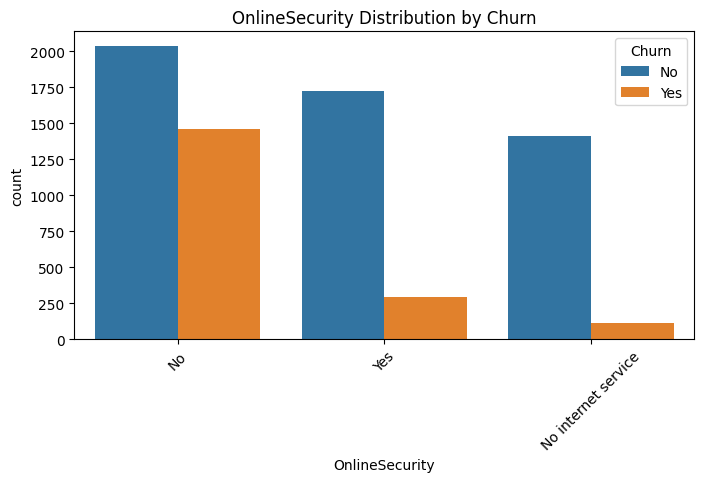

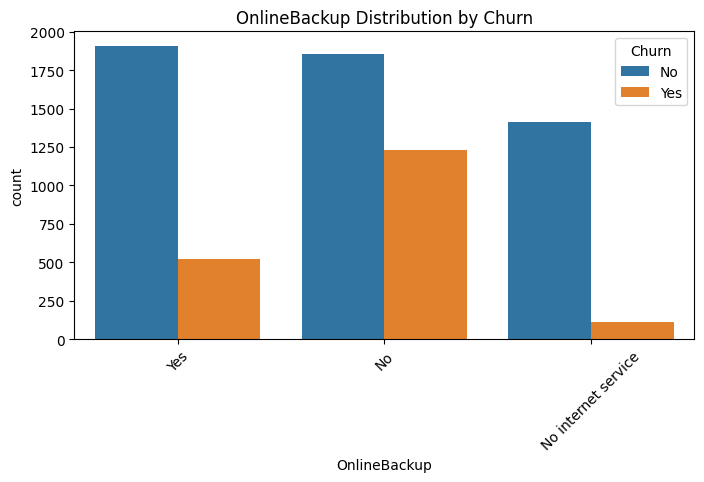

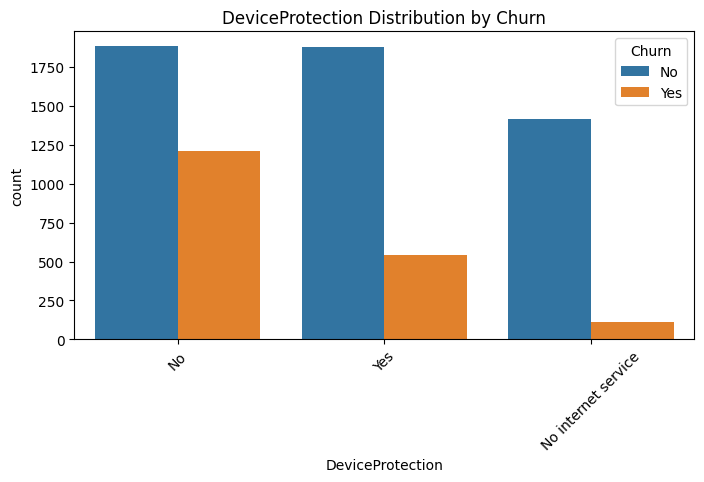

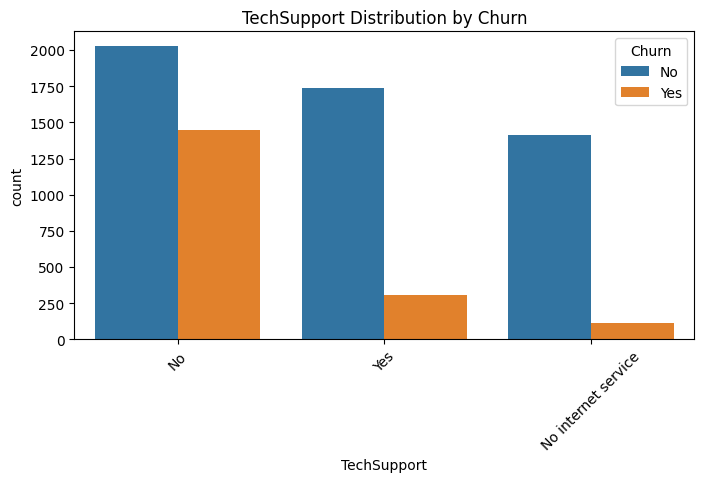

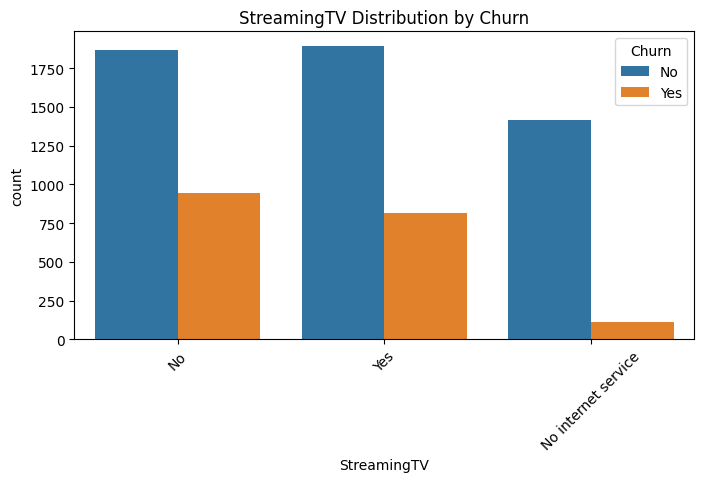

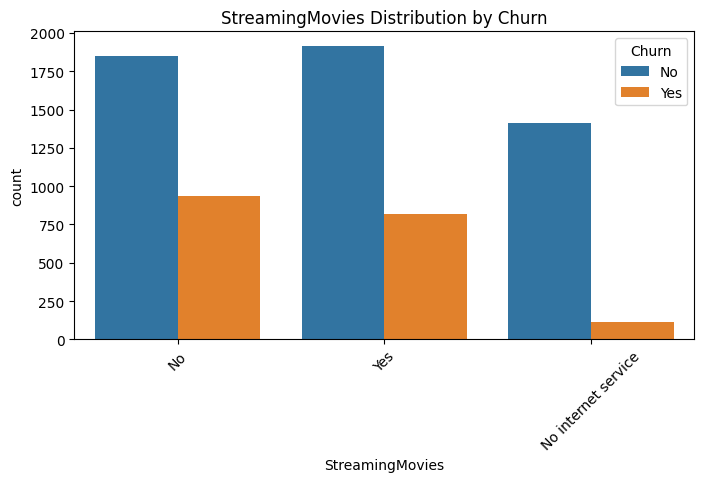

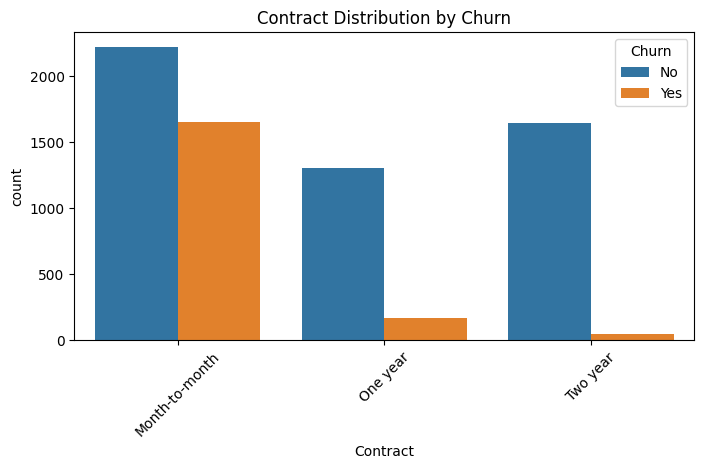

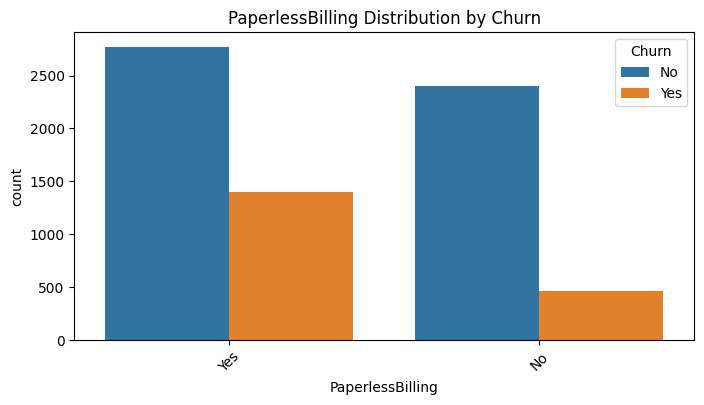

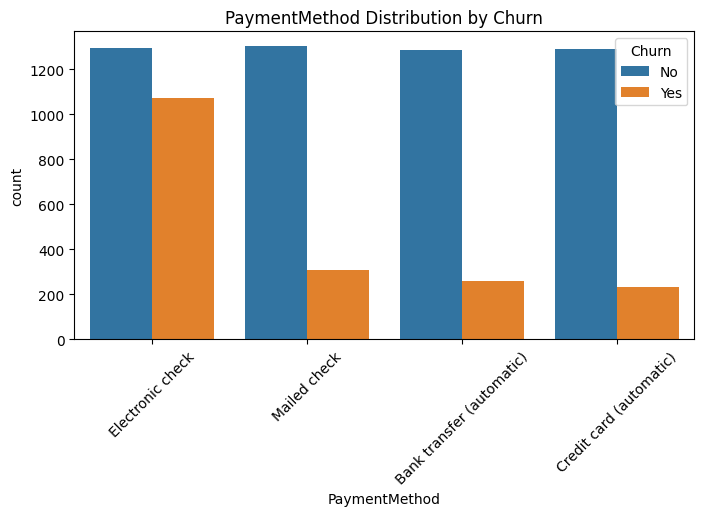

In [ ]:
#Categorical Features
cat_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
            'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
            'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
for col in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, data=df, hue='Churn')  # Hue shows churn split
    plt.title(f'{col} Distribution by Churn')
    plt.xticks(rotation=45)
    plt.show()

Insights: Higher churn in month-to-month contracts, fiber optic internet, no online security/tech support, electronic check payments. Seniors churn more; families (partners/dependents) churn less.

# Relationships and Correlations

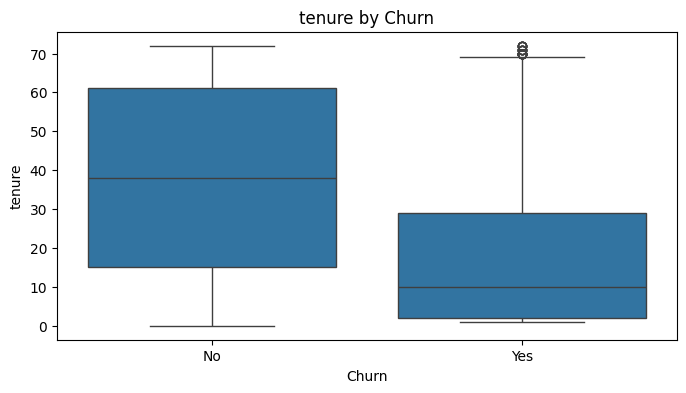

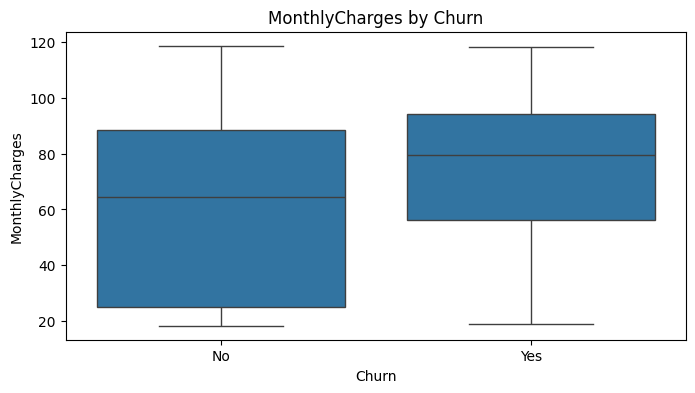

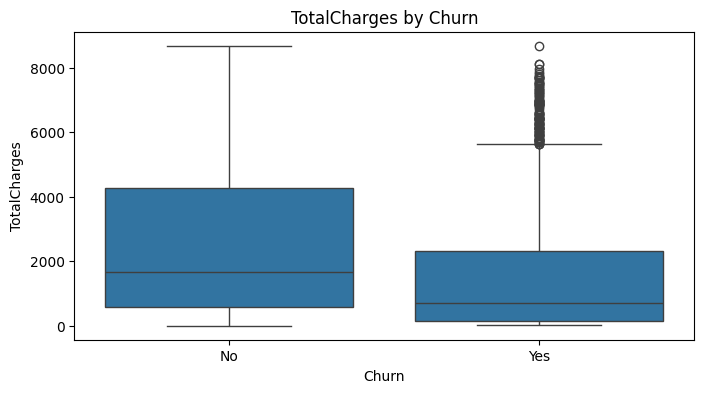

In [ ]:
#Boxplots for Numericals by Churn
for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='Churn', y=col, data=df)
    plt.title(f'{col} by Churn')
    plt.show()

Insights: Churners have lower tenure, higher monthly charges, lower total charges (short-term, expensive plans)

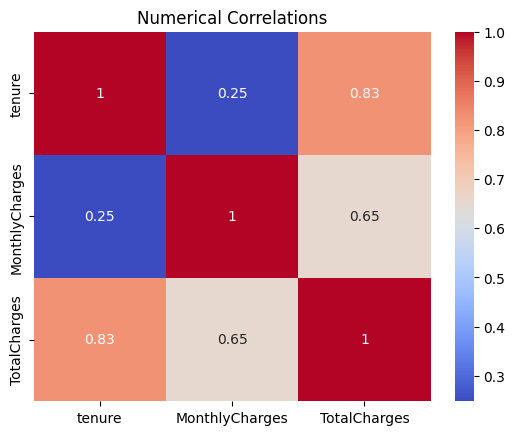

In [ ]:
#Correlation Heatmap (encode categoricals first for full view)

# Simple numerical correlation
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Numerical Correlations')
plt.show()

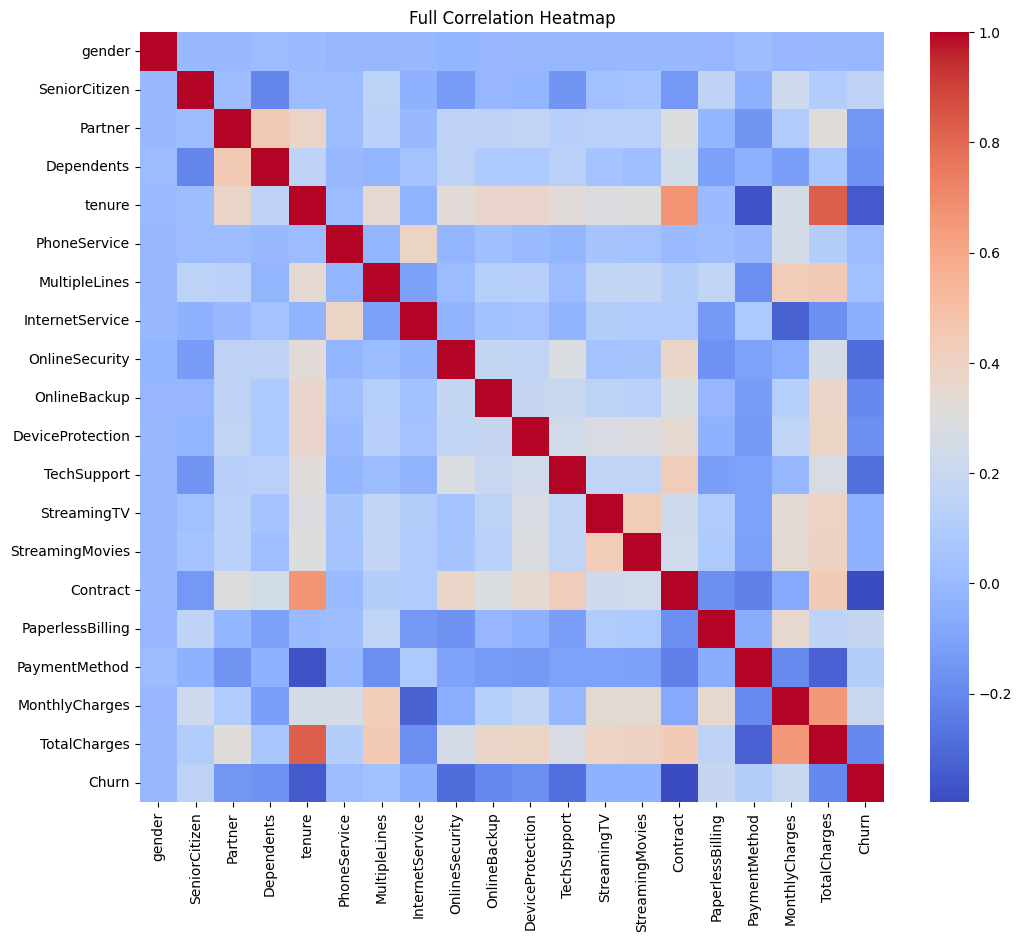

In [ ]:
# For full (encode categoricals to numeric)
from sklearn.preprocessing import LabelEncoder
df_encoded = df.copy()
for col in df_encoded.select_dtypes(include='object').columns:
    if col != 'Churn':  # Encode features only
        df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])
df_encoded['Churn'] = df_encoded['Churn'].map({'Yes': 1, 'No': 0})
corr_full = df_encoded.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_full, annot=False, cmap='coolwarm')
plt.title('Full Correlation Heatmap')
plt.show()

Insights: Strong negative correlation between tenure and churn; positive with monthly charges. Contract and services correlate with retention.

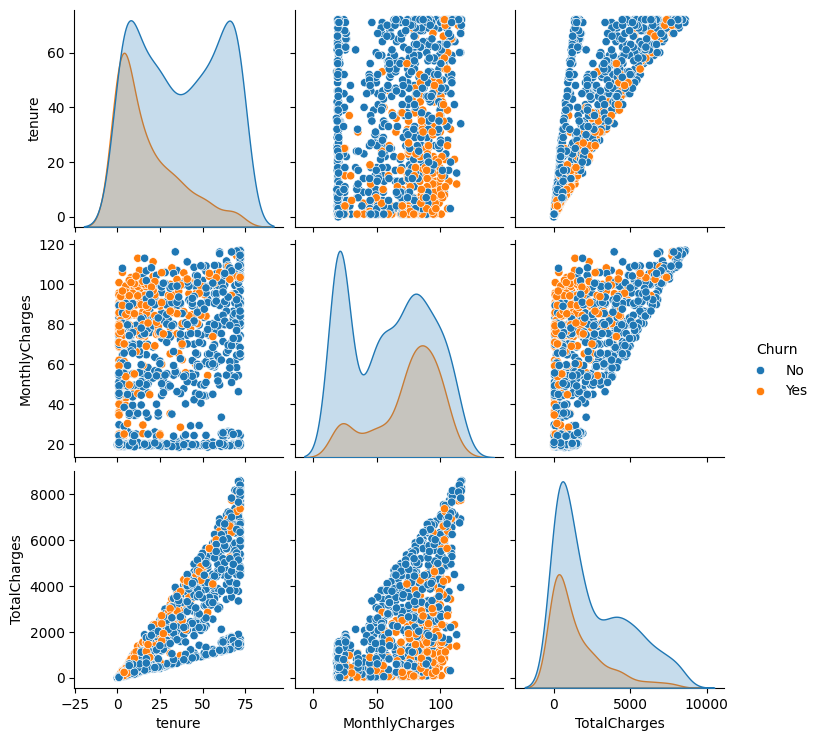

In [ ]:
#Pairplot (for quick overview)
sns.pairplot(df.sample(1000)[num_cols + ['Churn']], hue='Churn')
plt.show()

Insights: Clear separations in tenure/charges by churn

## Key Insights from EDA
- **Imbalance**: 73% non-churn, 27% churn – models should handle this.
- **Tenure Impact**: Customers with tenure < 10 months churn more (short-term loyalty issues).
- **Contract Type**: Month-to-month has ~40% churn rate vs. ~10% for 2-year.
- **Services**: No fiber optic or add-ons like security increases churn.
- **Demographics**: Seniors (42% churn) and no partners/dependents churn more.
- **Charges**: High monthly (>70) correlates with churn, despite lower total.